<a href="https://colab.research.google.com/github/Alex112525/LangGraph-notebooks/blob/main/Parallelization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install langgraph langgraph-sdk langgraph-checkpoint-sqlite langsmith langchain-community langchain-core langchain-openai tavily-python wikipedia

In [2]:
import os
import operator
from datetime import datetime
from typing import Any, Annotated
from typing_extensions import TypedDict

from google.colab import userdata
from IPython.display import Image, display, Markdown

In [3]:
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

In [4]:
from langchain_openai import AzureChatOpenAI
from langchain_community.retrievers import TavilySearchAPIRetriever

In [5]:
os.environ["AZURE_OPENAI_API_KEY"] = userdata.get('Azure_openai')
os.environ["AZURE_OPENAI_ENDPOINT"] = userdata.get('Endpoint_openai')
os.environ["TAVILY_API_KEY"] = userdata.get('Tavily_API_key')

## Utils Funtions

In [6]:
def get_model(model:str="DASH-mini", temp:float=0.1, max_tokens:int=100):
  """Get model from Azure OpenAI"""
  model = AzureChatOpenAI(
        openai_api_version="2024-02-15-preview",
        azure_deployment=model,
        temperature=temp,
        max_tokens=max_tokens,
    )
  return model

In [7]:
gpt4o_mini = get_model(max_tokens= 500)

In [8]:
class State(TypedDict):
  # Append from Sources
  question: str
  answer: str
  context: Annotated[list, operator.add]

### Tools to search

In [9]:
def web_search(state):
  """Retrieve docs from web search"""

  # Search
  print(datetime.now(), "- Start Web search")
  tavily_search = TavilySearchResults(max_results = 3)
  search_docs = tavily_search.invoke(state["question"])

  # Format
  formatted_search_docs = "\n---\n".join(
      [f'<Document href={doc["url"]}/>\n{doc["content"]}\n </Document>' for doc in search_docs]
  )
  print(datetime.now(), "- End Web search")
  return {"context": [formatted_search_docs]}

In [10]:
def wiki_search(state):
  """Retrieve docs from wikipedia"""

  # Search
  print(datetime.now(), "- Start Wiki search")
  search_docs = WikipediaLoader(query=state["question"], load_max_docs=2).load()

  # Format
  formatted_search_docs = "\n---\n".join(
      [f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>' for doc in search_docs]
  )
  print(datetime.now(), "- End Wikipedia search")
  return {"context": [formatted_search_docs]}

In [11]:
def generate_answer(state):
  """Node to answer a question"""

  # Get state
  context = state["context"]
  question = state["question"]

  # Template
  answer_template = """Answer the question {question}, using the following context {context}"""
  answer_instructions = answer_template.format(question=question, context=context)

  # Answer
  ans = gpt4o_mini.invoke([SystemMessage(content=answer_instructions)])

  return {"answer": ans}

### Build Graph

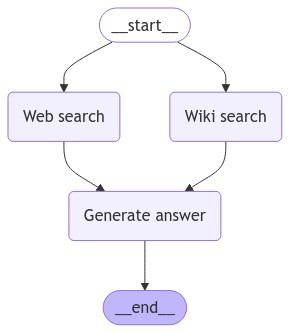

In [12]:
# Add nodes
builder = StateGraph(State)

builder.add_node("Web search", web_search)
builder.add_node("Wiki search", wiki_search)
builder.add_node("Generate answer", generate_answer)

# Flow
builder.add_edge(START, "Wiki search")
builder.add_edge(START, "Web search")
builder.add_edge("Web search", "Generate answer")
builder.add_edge("Wiki search", "Generate answer")
builder.add_edge("Generate answer", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
results = graph.invoke({"question": "What is Attention in human cognition"})

2024-10-03 01:34:44.699734 - Start Web search
2024-10-03 01:34:44.706278 - Start Wiki search
2024-10-03 01:34:46.978555 - End Wikipedia search
2024-10-03 01:34:47.546697 - End Web search


Looking at the time, we can see that both searches were running in parallel at the same time.

In [14]:
results["context"]

['<Document href=https://practicalpie.com/attention-psychology//>\nIt underscores a fundamental aspect of human cognition: our attention is limited, even when focused intently on a task. It reveals the boundaries of human perception and illustrates how easy it is for us to miss even glaringly obvious events when our attention is directed elsewhere. This has broader implications in driving safety, aviation, and ...\n </Document>\n---\n<Document href=https://www.verywellmind.com/what-is-attention-2795009/>\nAttention allows you to "tune out" information, sensations, and perceptions that are not relevant at the moment and instead focus your energy on the information that\'s important.\u200b\nNot only does our attentional system allow us to focus on something specific in our environment while tuning out irrelevant details, but it also affects our perception of the stimuli surrounding us.\n In his 1890 book “The Principles of Psychology,” psychologist and philosopher William James wrote tha

In [15]:
display(Markdown(results["answer"].content))

Attention in human cognition refers to the mental process that allows individuals to focus on specific stimuli or tasks while filtering out irrelevant information. This cognitive function is crucial for managing the limited capacity of our attentional resources, enabling us to concentrate on what is most important at any given moment. 

As highlighted in the provided context, attention is inherently limited, meaning that even when we are intensely focused, we can easily miss significant events occurring around us. This limitation underscores the boundaries of human perception and has practical implications in various fields, such as driving and aviation.

William James, a prominent psychologist, described attention as the "taking possession by the mind" of one out of several possible objects or thoughts, emphasizing the need to withdraw from some stimuli to effectively engage with others. The ability to manage attention is influenced by factors such as interest in the stimulus and the presence of distractions.

There are different types of attention, each serving distinct functions in our cognitive processes. Effective attention management is essential for making sense of the world, as it allows us to tune out extraneous stimuli, both external and internal, and remain focused on our tasks.

In [16]:
results = graph.invoke({"question": "What is a Transformer and why is important in AI"})

2024-10-03 01:34:49.408271 - Start Web search
2024-10-03 01:34:49.417260 - Start Wiki search
2024-10-03 01:34:51.760849 - End Wikipedia search
2024-10-03 01:34:51.901916 - End Web search


In [17]:
display(Markdown(results["answer"].content))

A **Transformer** is a type of neural network architecture that has revolutionized the field of artificial intelligence (AI), particularly in natural language processing (NLP). Introduced in a 2017 paper titled "Attention is All You Need," the Transformer architecture is designed to handle sequential data, such as text, by using a mechanism called **self-attention**. This allows the model to weigh the importance of different words in a sentence relative to each other, capturing context and relationships more effectively than previous models like recurrent neural networks (RNNs) or convolutional neural networks (CNNs).

### Importance in AI:

1. **Contextual Understanding**: Transformers excel at understanding the interplay of words in a sentence, which is crucial for tasks like translation, summarization, and sentiment analysis. Models like BERT and GPT, which are based on the Transformer architecture, have set new benchmarks in these areas.

2. **Scalability**: Transformers can be scaled up to billions of parameters, enabling them to capture a wide range of human language and knowledge. This scalability has led to the development of large language models that can perform various tasks with minimal fine-tuning.

3. **Transfer Learning**: The architecture supports techniques like transfer learning, allowing models to be pre-trained on large datasets and then fine-tuned for specific tasks. This makes it easier and faster to customize models for different applications.

4. **Generative Capabilities**: Transformers are foundational to generative AI, enabling the creation of coherent and contextually relevant text, images, and other media. This has led to significant advancements in creative tools and applications.

5. **Broader Applications**: Beyond language, Transformers are being applied in fields like genomics, where they can analyze DNA sequences similarly to language, predicting the effects of genetic mutations and identifying disease-related patterns.

In summary, the Transformer architecture is crucial in AI because it enhances the ability of machines to understand and generate human-like text, supports large-scale learning, and opens up new avenues for innovation across various domains.